In [ ]:
!pip install pandas 
!pip install numpy
!pip install matplotlib
!pip install scikit-learn 
!pip install seaborn
!pip install gradio


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1: Imports & Setup

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make plots look nice
sns.set(style="whitegrid")
%matplotlib inline

## 2: Generate Dummy Data (The "Simulation")

In [21]:
# Make sure the .csv file is in the same folder as your notebook
df = pd.read_csv('data.csv')

# Check if it loaded correctly
df.head() 
# --- SIMULATION MODE: Generate 1000 fake customers ---
np.random.seed(42) # For reproducible results
n_samples = 1000

data = {
    'SeniorCitizen': np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2]),
    'Tenure_Months': np.random.randint(1, 72, size=n_samples),
    'MonthlyCharges': np.random.uniform(30, 120, size=n_samples),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n_samples),
    'PaperlessBilling': np.random.choice(['Yes', 'No'], size=n_samples),
    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], size=n_samples)
}

df = pd.DataFrame(data)

# Let's create a 'Churn' column based on logic (so the ML has patterns to find)
# Logic: High costs + Low tenure + Month-to-month contract = High Churn Risk
df['Churn'] = 'No'
conditions = (df['MonthlyCharges'] > 80) & (df['Tenure_Months'] < 12) & (df['Contract'] == 'Month-to-month')
df.loc[conditions, 'Churn'] = 'Yes'

# Add some random noise churn (real life is messy)
random_churn_indices = np.random.choice(df.index, size=100, replace=False)
df.loc[random_churn_indices, 'Churn'] = 'Yes'

print("Dataset Created Successfully!")
df.head()

Dataset Created Successfully!


,SeniorCitizen,Tenure_Months,MonthlyCharges,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,47,96.754086,Two year,No,Electronic check,No
1,1,12,109.330570,Two year,No,Bank transfer,No
2,0,62,55.011189,Two year,Yes,Bank transfer,No
3,0,8,47.455848,Month-to-month,No,Credit card,No
4,0,21,109.183484,One year,No,Electronic check,No


## 3: Exploratory Data Analysis (EDA)

C:\Users\Ayush\AppData\Local\Temp\ipykernel_7312\1163112210.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='pastel')


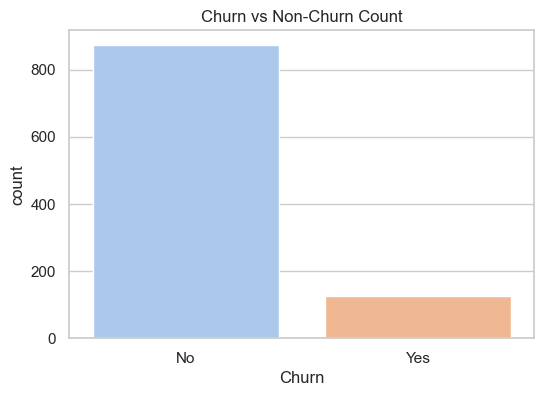

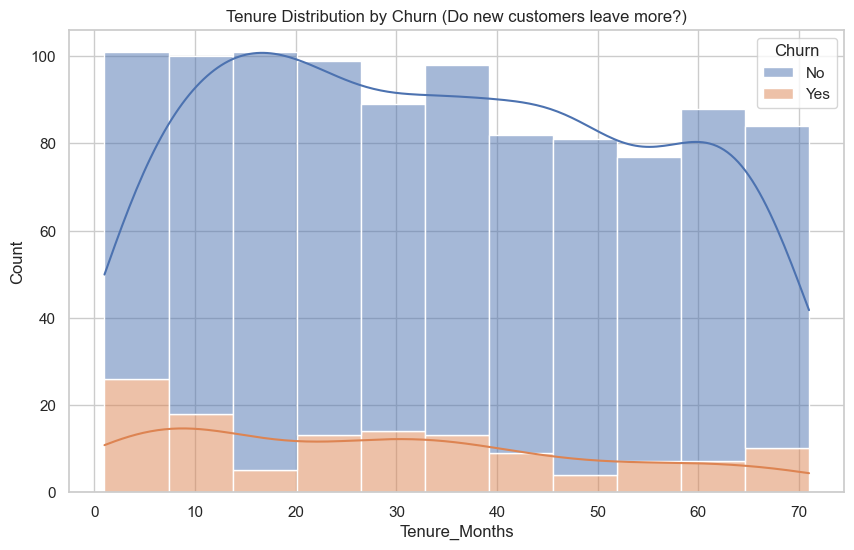

In [22]:
# 1. Visualize the Churn Split
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='pastel')
plt.title("Churn vs Non-Churn Count")
plt.show()

# 2. Tenure Distribution
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Tenure_Months', hue='Churn', multiple='stack', kde=True)
plt.title("Tenure Distribution by Churn (Do new customers leave more?)")
plt.show()

## 4: Preprocessing (Getting Ready for AI)

In [23]:
# Convert 'Churn' to 0 and 1
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Convert categorical variables (Contract, PaymentMethod, etc.) into dummy variables
df_processed = pd.get_dummies(df, drop_first=True)

# Separate features (X) and target (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Split into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data processed. Ready for training!")
print(f"Training features shape: {X_train.shape}")

Data processed. Ready for training!
Training features shape: (800, 9)


## 5: Model Training

In [24]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("Training complete.")

Training the model...
Training complete.


## 6: Evaluation & Visualization

Model Accuracy: 86.50%


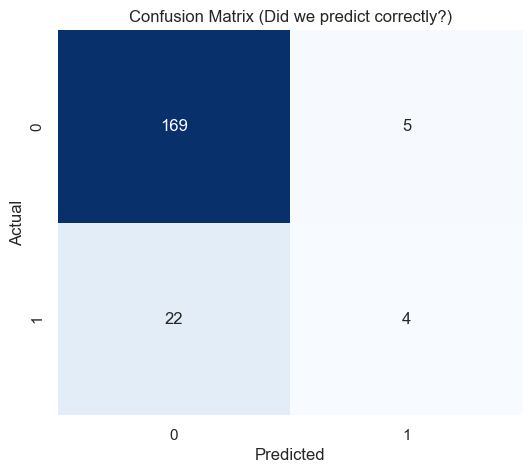

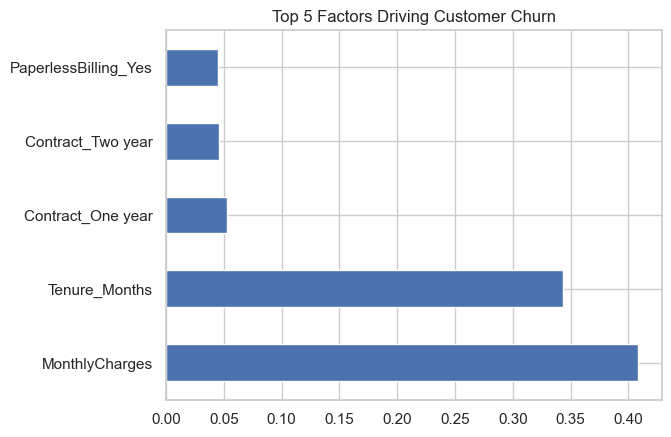

In [25]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc*100:.2f}%")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Did we predict correctly?)')
plt.show()

# Show Feature Importance (What drives churn?)
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(5).plot(kind='barh')
plt.title("Top 5 Factors Driving Customer Churn")
plt.show()

## 7. Add GUI

In [ ]:
import gradio as gr
import pandas as pd

def predict_churn(senior_citizen, tenure, monthly_charges, contract, paperless, payment_method):
    # 1. Prepare the input data structure
    # We create a single row DataFrame with the same columns as our training data (X_train)
    # We initialize everything to 0 first.
    input_df = pd.DataFrame(0, index=[0], columns=X_train.columns)
    
    # 2. Fill in the numerical/simple values
    input_df['SeniorCitizen'] = 1 if senior_citizen else 0
    input_df['Tenure_Months'] = tenure
    input_df['MonthlyCharges'] = monthly_charges
    
    # 3. Manually map the "One-Hot Encoded" columns
    # The model expects specific columns like 'Contract_One year'. 
    # If the user selects 'Month-to-month', all Contract columns stay 0.
    
    if contract == 'One year':
        input_df['Contract_One year'] = 1
    elif contract == 'Two year':
        input_df['Contract_Two year'] = 1
        
    if paperless == 'Yes':
        input_df['PaperlessBilling_Yes'] = 1
        
    if payment_method == 'Credit card':
        input_df['PaymentMethod_Credit card'] = 1
    elif payment_method == 'Electronic check':
        input_df['PaymentMethod_Electronic check'] = 1
    elif payment_method == 'Mailed check':
        input_df['PaymentMethod_Mailed check'] = 1
        
    # 4. Make the Prediction
    # We use predict_proba to get the percentage chance (0.0 to 1.0)
    probability = model.predict_proba(input_df)[0][1]
    
    # 5. Return a clear message
    if probability > 0.5:
        return f"⚠️ High Risk! Churn Probability: {probability:.1%}"
    else:
        return f"✅ Safe. Churn Probability: {probability:.1%}"

# --- Build the Interface ---
interface = gr.Interface(
    fn=predict_churn,
    inputs=[
        gr.Checkbox(label="Is Senior Citizen?"),
        gr.Slider(minimum=0, maximum=72, label="Tenure (Months)"),
        gr.Number(label="Monthly Charges ($)"),
        gr.Dropdown(["Month-to-month", "One year", "Two year"], label="Contract Type"),
        gr.Radio(["Yes", "No"], label="Paperless Billing?"),
        gr.Dropdown(["Electronic check", "Mailed check", "Bank transfer", "Credit card"], label="Payment Method")
    ],
    outputs="text",
    title="🔮 Customer Churn Predictor",
    description="Adjust the customer details to see if the AI thinks they will leave."
)

# Launch it directly in the notebook
interface.launch()